
## Vision-for-Agriculture
Vision for Agriculture Segmenting and classifying aerial images of US farmland
Dataset intro
The challenge dataset contains 21,061 aerial farmland images captured throughout 2019 across the US. Each image consists of four 512x512 color channels, which are RGB and Near Infra-red (NIR). Each image also has a boundary map and a mask. The boundary map indicates the region of the farmland, and the mask indicates valid pixels in the image. Regions outside of either the boundary map or the mask are not evaluated.

This dataset contains six types of annotations: Cloud shadow, Double plant, Planter skip, Standing Water, Waterway, and Weed cluster. These types of field anomalies have great impacts on the potential yield of farmlands, therefore it is extremely important to accurately locate them. In the Agriculture-Vision dataset, these six patterns are stored separately as binary masks due to potential overlaps between patterns. Users are free to decide how to use these annotations.

Each field image has a file name in the format of (field id)_(x1)-(y1)-(x2)-(y2).(jpg/png). Each field id uniquely identifies the farmland that the image is cropped from, and (x1, y1, x2, y2) is a 4-tuple indicating the position in which the image is cropped. Please refer to our paper for more details regarding how we construct the dataset.

Your task
Using the dataset described above your task is to train a model to predict field anomalies on new images. Given a new input from the test set your task is to predict what class does each pixel belong to (one of the six anomalies or the background).

Submission
This year your submissions will not go through the Kaggle website. Due to issues with the privacy of the test set, you will use a platform codalab: https://competitions.codalab.org/competitions/23732

It is straightforward to use - you need to register your team and you can upload your predictions (up to 2 per day and 999 in total). You will see your scores instantly. Make sure your team name on codalab is in the following format "comp540_netid_netid_*". This will be important for us to be able to see your results, keep track of your progress and extract the class leaderboard. Also beware - the scoring process on codalab takes about 6h!

The server expects you to format the predictions in the following way:

- for each image in the test set you should produce a prediction image in .png format, with filename **field-id_x1-y1-x2-y2.png**. The image ID 'field-id_x1-y1-x2-y2' must match the ID of the predicted image exactly. Each png file in your submission will be loaded using

numpy.array(PIL.Image.open(‘field-id_x1-y1-x2-y2.png’))

So we recommend you save the predictions using

PIL.Image.fromarray(pred).save(‘field-id_x1-y1-x2-y2.png’)

- the prediction image should have the same size as the input image and each pixel should contain a label from 0-6 indicating the anomaly type/background. Specifically:

0 - background

1 - cloud_shadow

2 - double_plant

3 - planter_skip

4 - standing_water

5 - waterway

6 - weed_cluster

This label order will be strictly followed during evaluation.

- then you should zip the folder with prediction images and upload it to codalab.

Evaluation metric
We use mean Intersection-over-Union (mIoU) as our main quantitative evaluation metric, which is one of the most commonly used measures in semantic segmentation datasets. The mIoU is computed as:



Where c is the number of annotation types (c = 7 in our dataset, with 6 patterns + background), Pc and Tc are the predicted mask and ground truth mask of class c respectively.

Since our annotations may overlap, we modify the canonical mIoU metric to accommodate this property. For pixels with multiple labels, a prediction of either label will be counted as a correct pixel classification for that label, and a prediction that does not contain any ground truth labels will be counted as an incorrect classification for all ground truth labels.

A more detailed explanation can be found here: https://github.com/SHI-Labs/Agriculture-Vision .

First steps
We want to encourage you to take the following steps first:

1) Check out the "Data" tab, download the data and get familiar with the available dataset. More details about the dataset are under the Data tab.

2) Check out the following page where the original competition instructions are placed: https://github.com/SHI-Labs/Agriculture-Vision

3) Make an account on codalab and register your team here: https://competitions.codalab.org/competitions/23732

4) Start experimenting with simple models and get your submissions up on the server

IMPORTANT: make sure your team name on codalab is in the following format "comp540_netid_netid_*". This will be important for us to be able to see your results and extract the class leaderboard!


## Apply mask and boundry to the original picture for both RBG and NIR channel
Build parsers to help loading data
Helper functions are included in utils.py file

In [6]:
import os 
from PIL import Image
from numpy import asarray
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import pickle
import utils
from matplotlib import image as mpimg
import matplotlib
import random
import seaborn as sns
from collections import Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
def load_agri_version(train_dir,labels_dir):
    '''
    Load label data according to the required 6 classes
    Input: Train_directory ---- str
           Labels_directory ---- str
    Output: Label data ---- dict[list]   
    '''
    labels_init = defaultdict(list)
    # initialize label dictionary according to the training data
    for f in [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]:
        labels_init[f[0:-4]] = [0,0,0,0,0,0]
    for ind, l in enumerate([f for f in os.listdir(labels_dir)][1:]):
        direc = labels_dir + l
        for file in tqdm([f for f in os.listdir(direc) if os.path.isfile(os.path.join(direc, f))]):
            if file != ".DS_Store":
                # Calculate coverage according to the corresponding label
                rate = (np.array(Image.open(os.path.join(direc, file)).convert('L'))/255).mean()
                labels_init[file[0:-4]][ind] = rate
    # save dictionary for later use
    f = open("y_train.pkl","wb")
    pickle.dump(labels_init,f)
    f.close()
    return labels_init

train_dir = "/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/train/images/rgb"
labels_dir = "/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/train/labels/"
y_train = utils.load_agri_version(train_dir,labels_dir,"y_train")

In [ ]:
dbfile = open('y_train.pkl', 'rb')     
db = pickle.load(dbfile)

In [2]:
def image_argment_train(fig_id):
    '''
    Process single image in validation set
    Input: Image Id ---- str
    Output: Processed image (Apply mask + boundry, stack NIR) ---- np.array
    '''
    rgb_path = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/train/images/rgb'
    nir_path = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/train/images/nir'
    bdry_path = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/train/boundaries'
    mask_path = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/train/masks'
    
    rgb_img = mpimg.imread(os.path.join(rgb_path, fig_id + '.jpg'))/255
    nir_img = mpimg.imread(os.path.join(nir_path, fig_id + '.jpg')).reshape((512,512,1))/255
    bdry_img = mpimg.imread(os.path.join(bdry_path, fig_id + '.png'))
    mask_img = mpimg.imread(os.path.join(mask_path, fig_id + '.png'))
    #input_img = np.concatenate([rgb_img, nir_img], axis=2) / 255. # Concatenate the RGB and NIR
    
    # stack mask and boundry
    final_mask = np.multiply(mask_img,bdry_img).reshape(512,512,1)
    
    # add nir channel to original data
    input_img = np.concatenate([rgb_img, nir_img], axis=2) / 255. # Concatenate the RGB and NIR
    
    # apply mask and boundry to image
    final_img_rgb = np.multiply(final_mask,rgb_img)
    final_img_nir = np.multiply(final_mask,nir_img)

    return final_img_rgb, final_img_nir

final_img_rgb, final_img_nir= utils.image_argment_train('UI36U6X7A_984-5109-1496-5621')   

In [3]:
def save_process_img_train (fig_id, path_tar_rgb, path_tar_nir, resize_x = 512, resize_y = 512):
    
    '''
    Rescale the processed image and save to the required directory
    Input: fig_id ---- str
           path_tar_rgb ---- str
           path_tar_nir ---- nir
           resize_x ---- int
           resize_y ---- int
    '''
    try:
        path_tar_rgb = os.path.join(path_tar_rgb,str(resize_x) + "*" + str(resize_y))
        os.makedirs(path_tar_rgb)
    except:
        pass
            
    try:
        path_tar_nir = os.path.join(path_tar_nir,str(resize_x) + "*" + str(resize_y))
        os.makedirs(path_tar_nir)
    except:
        pass
    
    # process rgb and nir data with mask and boundry
    final_img_rgb, final_img_nir = image_argment_train(fig_id)
    # resize and save rgb data
    matplotlib.image.imsave(os.path.join(path_tar_rgb, fig_id + '.jpg'), final_img_rgb)
    rgb_resize = Image.open(os.path.join(path_tar_rgb, fig_id + '.jpg')).resize((resize_x,resize_y))
    rgb_resize.save(os.path.join(path_tar_rgb, fig_id + '.jpg'),quality = 90)
    
    # resize and save nir data
    final_img_nir = np.concatenate([final_img_nir, final_img_nir, final_img_nir], axis=2)
    matplotlib.image.imsave(os.path.join(path_tar_nir, fig_id + '.jpg'), final_img_nir)
    nir_resize = Image.open(os.path.join(path_tar_nir, fig_id + '.jpg')).resize((resize_x,resize_y))
    nir_resize.save(os.path.join(path_tar_nir, fig_id + '.jpg'),quality = 90)
    
    return rgb_resize, nir_resize

path_tar_rgb = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/rgb'
path_tar_nir = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/nir'
rgb, nir = utils.save_process_img_train ('UI36U6X7A_984-5109-1496-5621', path_tar_rgb, path_tar_nir,256,256)

In [5]:
def process_tarin(train_data, path_tar_rgb, path_tar_nir, resize_x = 30, resize_y = 30):
    '''
    Process training data, resize and save images of RGB and NIR channel
    Input: train_data ---- database.pkl
           path_tar_rgb ---- str
           path_tar_nir ---- str
           resize_x ---- int
           resize_y ---- int
    Output: None 
    '''
    dbfile = open(train_data, 'rb')     
    db = pickle.load(dbfile)
    for fig_id in tqdm(db):
        save_process_img_train (fig_id, path_tar_rgb, path_tar_nir, resize_x, resize_y)
    return None 
            
train_data = 'y_train.pkl'
path_tar_rgb = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/rgb'
path_tar_nir = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/nir'
process_tarin(train_data, path_tar_rgb, path_tar_nir, resize_x = 30, resize_y = 30)

100%|██████████| 12901/12901 [15:41<00:00, 13.70it/s]


In [44]:
path_tar_rgb = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/rgb'
path_tar_nir = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/nir'
test = utils.save_process_img_train ('UI36U6X7A_984-5109-1496-5621', path_tar_rgb, path_tar_nir,64,64)

In [ ]:
def subsample_tarin_flatened(train_data, number_train):
    '''
    Subsample the training set to number_training set
    Input:
    Output:
    '''
    dbfile = open(train_data, 'rb')     
    db = pickle.load(dbfile)

In [ ]:
x_data = np.array( [np.array(cv2.imread(imagePath[i])) for i in range(len(imagePath))] )
pixels = x_data.flatten().reshape(1000, 12288)
print pixels.shape

In [74]:
count, tar_num = 0, 5000
dict_sub = {}
dbfile = open(train_data, 'rb')     
db = pickle.load(dbfile)
path_tar_rgb = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/rgb'
path_tar_nir = '/Users/zhuqing/Documents/Github/Vision-for-Agriculture/Agriculture-Vision/Process/train/nir'
while count < tar_num:
    key = random.choice(list(db.keys()))
    if key not in dict_sub:
        dict_sub[key] = db[key]
        count += 1
for key in tqdm(dict_sub):
    rgb, nir = utils.save_process_img_train (key,path_tar_rgb, path_tar_nir,64,64)
    flat_img = list(np.array(rgb).flatten())
    dict_sub[key] += flat_img
    
df = pd.DataFrame(dict_sub)

100%|██████████| 5000/5000 [06:05<00:00, 13.69it/s]


In [75]:
df.to_csv('flatened_data.csv')

### Provide statistic result for y_labels

In [8]:
train_data = 'y_train.pkl'
dbfile = open(train_data, 'rb')     
db = pickle.load(dbfile)
y_train = np.array(pd.DataFrame(db)).T
bg = (1 - y_train.sum(axis = 1) ).reshape(-1,1)
y_train_wb = np.hstack((bg,y_train)).argmax(axis = 1)

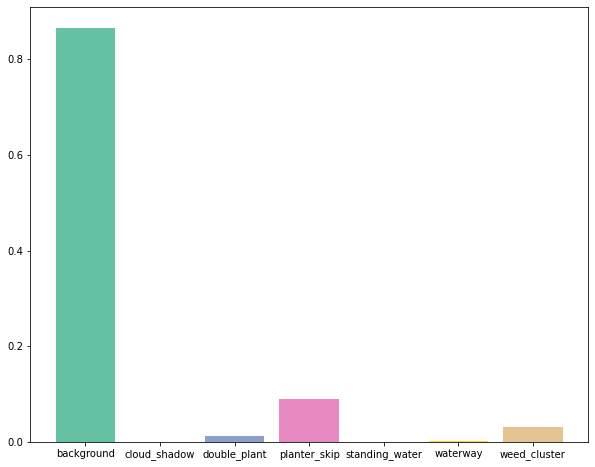

In [9]:
labels_train = sorted(Counter(y_train_wb).items(), key = lambda x: x[0])
label = [x[1]/12901 for x in labels_train]
classes = ['background','cloud_shadow','double_plant','planter_skip','standing_water','waterway','weed_cluster']
x_pos = np.arange(len(label))
# Create bars with different colors
plt.bar(x_pos, label, color = sns.color_palette("Set2")[:7])
# Create names on the x-axis
plt.xticks(x_pos, classes)
# Show graph
plt.show()

In [23]:
df = pd.DataFrame(np.hstack((bg,y_train)))
df.head()

,0,1,2,3,4,5,6
0,0.817406,0.0,0.000000,0.182594,0.000000,0.0,0.0
1,0.964241,0.0,0.000000,0.000000,0.035759,0.0,0.0
2,0.151699,0.0,0.604877,0.243423,0.000000,0.0,0.0
3,0.945610,0.0,0.000000,0.054390,0.000000,0.0,0.0
4,0.225468,0.0,0.000000,0.774532,0.000000,0.0,0.0


In [26]:
df.columns = ['Background', 'Cloud', 'Double Plant', 'Planter Skip', 'Standing Water', 'Waterway', 'Weed Cluster']

array([[<AxesSubplot:title={'center':'Background'}>,
        <AxesSubplot:title={'center':'Cloud'}>,
        <AxesSubplot:title={'center':'Double Plant'}>],
       [<AxesSubplot:title={'center':'Planter Skip'}>,
        <AxesSubplot:title={'center':'Standing Water'}>,
        <AxesSubplot:title={'center':'Waterway'}>],
       [<AxesSubplot:title={'center':'Weed Cluster'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

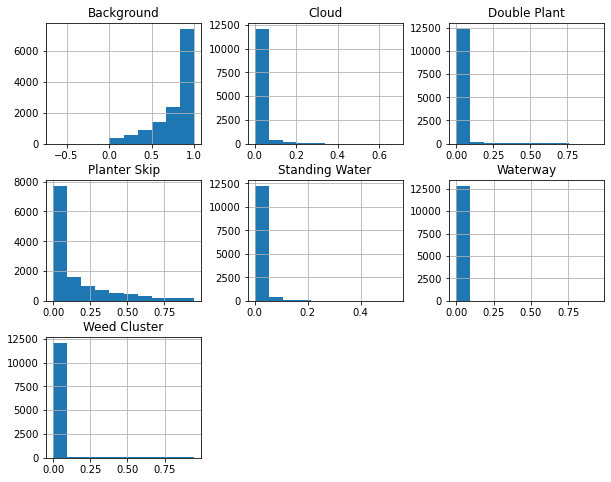

In [43]:
df = pd.DataFrame(np.hstack((bg,y_train)))
df.columns = ['Background', 'Cloud', 'Double Plant', 'Planter Skip', 'Standing Water', 'Waterway', 'Weed Cluster']
df.hist()

In [26]:
train_data = 'y_train.pkl'
dbfile = open(train_data, 'rb')  
db = pickle.load(dbfile)

In [30]:
df = pd.DataFrame(db)
df.to_csv('y_label.csv')

In [31]:
train_data = 'y_val.pkl'
dbfile = open(train_data, 'rb')  
db = pickle.load(dbfile)
df = pd.DataFrame(db)
df.to_csv('y_val.csv')

### DNN part

In [ ]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
try:
    os.makedirs('Image_process')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise